In [4]:
# Data Handling
import numpy as np
import pandas as pd
import scipy.spatial as sc_p


# Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [21]:
#Metaconstants
N = 512 #particle number
NL = 8 #particle number for each side
L = 40.0 #box longitude (angstroms)
Nt = 1000 #Number of timesteps


T_INF = 300.0 #Desired temperature
dt = 0.001 #Time step  10**(12) seconds
m = 39.948 # Mass of argon (umas)

#Thermometer time change
tao = 100*dt 


#Boltzmann constant:
KB = 1.3806E-23/1.66E-23;

In [22]:
#Initial conditions
def initial_conditions(N,L):
    #Velocity of particles:
    v1 = np.zeros(NL)
    v2 = np.zeros(NL)
    v3 = np.zeros(NL)
    vel = np.array(np.meshgrid(v1,v2,v3))
                   
    #Organization of particles:
    c1 = np.arange(0+L/(NL+1), L, L/(NL+1))
    c2 = np.arange(0+L/(NL+1), L, L/(NL+1))
    c3 = np.arange(0+L/(NL+1), L, L/(NL+1))
    pos = np.array(np.meshgrid(c1,c2,c3))

    # Track conditions
    r = {'x':pos[2].flatten().reshape((1,N)),'y':pos[0].flatten().reshape((1,N)),'z':pos[1].flatten().reshape((1,N))}
    v = {'x':vel[2].flatten().reshape((1,N)),'y':vel[0].flatten().reshape((1,N)),'z':vel[1].flatten().reshape((1,N))}
    return r, v

# Potential energy:
def U_pot(r):
    sigma = 3.4
    epsilon = 99.3975903614458
    return 4*epsilon*((sigma/r)**12-(sigma/r)**6)

# Force between particles:
def calc_force(r):
    sigma = 3.4
    epsilon = 99.3975903614458 #1.65E-21 / 1.66E-23
    return -24.0*epsilon/(sigma**2)*(sigma/r)**8*(2*(sigma/r)**6-1.0)

# Determine the minkowsky distance 1
def minkowski_distance1(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    return np.sum(y-x,axis=-1)

# Obtain the relative position
def relative_position(x):
    m,k = x.shape
    result = np.empty((m,m),dtype=float)
    for i in range(m):
        result[i,:] = minkowski_distance1(x[i],x)
    return result

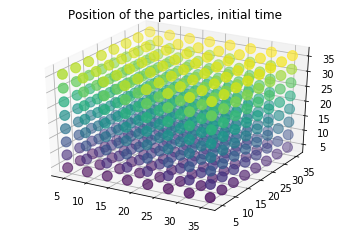

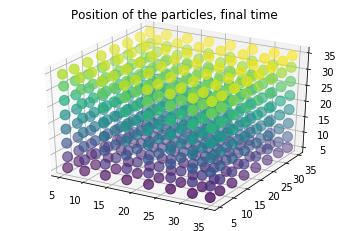

In [23]:
r, v = initial_conditions(N,L)

#Plot the initial positions of the particles
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Position of the particles, initial time')

ax.scatter(r['x'],r['y'],r['z'],c=np.arange(N), s=100)
plt.show()

K=[]
U=[]
T=[0]
V=[v]
Rx=[r['x'].reshape(N,)]
Ry=[r['y'].reshape(N,)]
Rz=[r['z'].reshape(N,)]

for t in range(1,Nt+1):
    
    T.append(t)
    
    #Obtain a numpy array with all the positions
    rtot = np.array([r['x'],r['y'],r['z']])

    # Search for the x,y, and z position for each particle
    xyz_pos = np.array([rtot[:,:,i] for i in range(N)]).reshape((N,3))

    # Obtain a single vector that has the x, y and z components individually
    x_pos = r['x'].reshape((N,1))
    y_pos = r['y'].reshape((N,1))
    z_pos = r['z'].reshape((N,1))
    

    # Generate distance matrices with minkoswki distance = 1 (relative position) Rj-Ri
    x_pos1 = relative_position(x_pos)
    y_pos1 = relative_position(y_pos)
    z_pos1 = relative_position(z_pos)

    # Remove the diagonal element of each of the distance matrices
    np.fill_diagonal(x_pos1, np.nan)
    x_pos1 = x_pos1[~np.isnan(x_pos1)].reshape(x_pos1.shape[0], x_pos1.shape[1] - 1)
    np.fill_diagonal(y_pos1, np.nan)
    y_pos1 = y_pos1[~np.isnan(y_pos1)].reshape(y_pos1.shape[0], y_pos1.shape[1] - 1)
    np.fill_diagonal(z_pos1, np.nan)
    z_pos1 = z_pos1[~np.isnan(z_pos1)].reshape(z_pos1.shape[0], z_pos1.shape[1] - 1)

    # Determine the distance of each particle:
    dist = sc_p.distance_matrix(xyz_pos,xyz_pos, p=2)

    #Plot the distance map
    #sns.heatmap(dist)
    #plt.title(f'Heatmap of distances between particles (shape:{dist.shape})')
    #plt.show()

    # Remove the diagonal elements (which will be 0 due to the particles location)
    np.fill_diagonal(dist, np.nan)
    dist = dist[~np.isnan(dist)].reshape(dist.shape[0], dist.shape[1] - 1)

    # Plot the new distance map
    #sns.heatmap(dist, vmin=0)
    #plt.title(f'Heatmap of distances between particles (shape:{dist.shape})')
    #plt.show()
    force = calc_force(dist)
    # Determine how much the force will affect each particle movement
    f = {'x':np.sum(force*x_pos1,axis=1),'y':np.sum(force*y_pos1,axis=1),'z':np.sum(force*z_pos1, axis=1)}

    KE = .5*m*np.sum(v['x']**2+v['y']**2+v['z']**2)
    K.append(KE)
    
    PE = 0.5*np.sum(U_pot(dist))
    U.append(PE)
    # Change each velocity correspondingly
    v['x'] = v['x'] + f['x']/m*dt
    v['y'] = v['y'] + f['y']/m*dt
    v['z'] = v['z'] + f['z']/m*dt

    #Change each position correspondingly
    r['x'] = r['x'] + v['x']*dt + .5*f['x']/m*dt**2
    r['y'] = r['y'] + v['y']*dt + .5*f['y']/m*dt**2
    r['z'] = r['z'] + v['z']*dt + .5*f['z']/m*dt**2
    V.append(v)
    Rx.append(r['x'].reshape(N,))
    Ry.append(r['y'].reshape(N,))
    Rz.append(r['z'].reshape(N,))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r['x'],r['y'],r['z'],c=np.arange(N), s=100)
plt.title('Position of the particles, final time')
plt.show()

In [24]:
x_df = pd.DataFrame(Rx,columns=[f"p{i+1}" for i in range(N)])
y_df = pd.DataFrame(Ry,columns=[f"p{i+1}" for i in range(N)])
z_df = pd.DataFrame(Rz,columns=[f"p{i+1}" for i in range(N)])

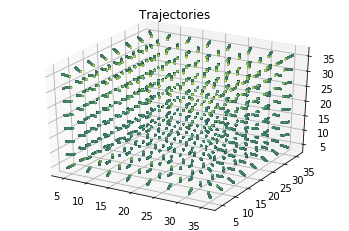

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('Trajectories')
ax.scatter(x_df,y_df,z_df,c=T*512, s=1)
#ax.scatter(x_df['p1'],y_df['p1'],z_df['p1'],c=T, s=100)
plt.show()

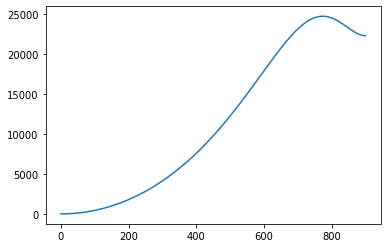

In [28]:
plt.plot(T[:900], K[:900])
